In [1]:
from keras.models import load_model
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet50V2  # adicionei isso
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score, classification_report
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Montando o google drive para acessar imagens
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive/Colab Notebooks/"

Mounted at /content/gdrive


Tamanho das imagens

In [3]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
# re-size all the images to this
IMAGE_SIZE = [400, 400]

In [4]:
train_path = path+'ebhi-split-2categorias/train'
valid_path = path+'ebhi-split-2categorias/val'
test_path = path+'ebhi-split-2categorias/test'

Declarando o modelo resnet50v2

In [5]:
resnet = ResNet50V2(input_shape=(400, 400, 3),
                    weights='imagenet', include_top=False)

94668760/94668760 [==============================] - 1s 0us/step


Não treina camadas

In [6]:
for layer in resnet.layers:
    layer.trainable = False

Adicionando as nossas camadas

In [7]:
x = Flatten()(resnet.output)
# x = Dense(64, activation='relu')(x) # descomentei e troquei de 1000 para 64
#prediction = Dense(len(folders), activation='softmax')(x)
prediction = Dense(1, activation='sigmoid')(x)

Criando o modelo

In [8]:
model = Model(inputs=resnet.input, outputs=prediction)

adicionei<br>
model.add(Conv2D(64, (3,3), activation='relu'))<br>
model.add(MaxPooling2D(2,2))<br>
model.add(Flatten())<br>
model.add(Dense(64, activation='relu'))<br>
model.add(Dropout(0.4))<br>
model.add(Dense(2, activation='softmax'))<br>
ate aqui

Visualizando a estrutura do modelo

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 406, 406, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 200, 200, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 202, 202, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

Declarando para o modelo as funções de custo e otimização

In [10]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2, #comentei
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(400, 400),
                                                 batch_size=32,
                                                 color_mode='rgb',  # adicionei isso
                                                 class_mode='binary')

Found 1163 images belonging to 2 classes.


In [14]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size=(400, 400),
                                            batch_size=32,
                                            shuffle=False,
                                            color_mode='rgb',  # adicionei isso
                                            class_mode='binary')
valid_set = valid_datagen.flow_from_directory(valid_path,
                                              target_size=(400, 400),
                                              batch_size=32,
                                              class_mode='binary')

Found 387 images belonging to 2 classes.
Found 387 images belonging to 2 classes.


Treinando o modelo

Epoch 1/10
37/37 [==============================] - 359s 9s/step - loss: 1.3663 - accuracy: 0.8994 - val_loss: 1.1860 - val_accuracy: 0.9406
Epoch 2/10
37/37 [==============================] - 82s 2s/step - loss: 0.5844 - accuracy: 0.9561 - val_loss: 0.9771 - val_accuracy: 0.9535
Epoch 3/10
37/37 [==============================] - 82s 2s/step - loss: 0.4578 - accuracy: 0.9639 - val_loss: 0.9541 - val_accuracy: 0.9561
Epoch 4/10
37/37 [==============================] - 81s 2s/step - loss: 0.3464 - accuracy: 0.9751 - val_loss: 0.8929 - val_accuracy: 0.9535
Epoch 5/10
37/37 [==============================] - 82s 2s/step - loss: 0.1452 - accuracy: 0.9854 - val_loss: 0.8701 - val_accuracy: 0.9535
Epoch 6/10
37/37 [==============================] - 84s 2s/step - loss: 0.1638 - accuracy: 0.9845 - val_loss: 0.8994 - val_accuracy: 0.9587
Epoch 7/10
37/37 [==============================] - 81s 2s/step - loss: 0.1986 - accuracy: 0.9837 - val_loss: 0.9314 - val_accuracy: 0.9587
Epoch 8/10
37/37 [=

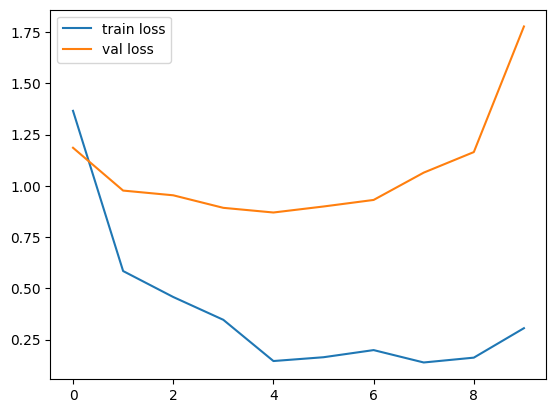

In [15]:
r = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_steps=len(valid_set)
)


Perda do treino

<Figure size 640x480 with 0 Axes>

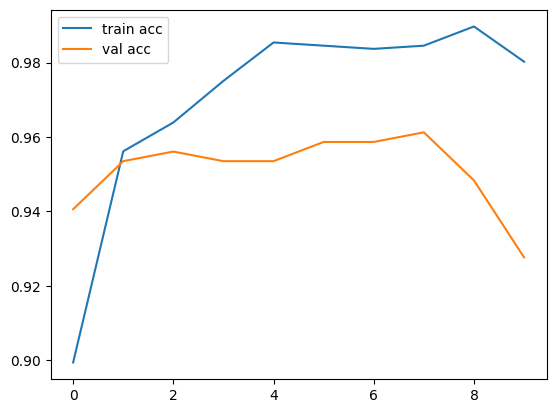

In [16]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossVal_loss_resnet')
plt.show()


Acurácias do treino

In [17]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('AccVal_acc_resnet')
plt.show()

<Figure size 640x480 with 0 Axes>

In [18]:
model.save('hist_model_resnet.h5')

Etapa de Testes

13/13 [==============================] - 11s 784ms/step
y predito:
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
y real:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

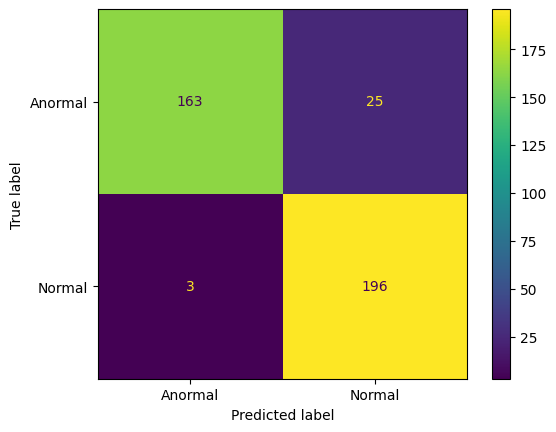

Accuracy score:  0.9276485788113695


In [19]:
resnet_model = model

t = time.time()
# Usando o modelo para predição das amostras de teste
y_pred = resnet_model.predict(test_set)
# Reset
#test_set.reset()
#loss, acc = resnet_model.evaluate(test_set)
#aux = np.argmax(aux, axis=1)
y_pred = np.where(y_pred > 0.5, 1, 0).flatten()
print("y predito:")
print(y_pred)
y_true = test_set.classes
print("y real:")
print(y_true)
# Método para calcular o valor F1-Score
print('F1-Score: {}'.format(f1_score(y_true, y_pred, average='macro')))
# Método para calcular a Precision
print('Precision : {}'.format(precision_score(y_true, y_pred, average='macro')))
# Método para calcular o Recall
print('Recall: {}'.format(recall_score(y_true, y_pred, average='macro')))

print('Matriz de Confusão:')
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Anormal','Normal'])
cm_display.plot()
plt.savefig('Matriz-resnet')
plt.show()

print ('Accuracy score: ', accuracy_score(y_true, y_pred))
#print('Acuracia obtida com o resnet no Conjunto de Teste EBHI: {:.2f}'.format(
#    acc))



Avaliando no UnitoPatho

Found 600 images belonging to 2 classes.
19/19 [==============================] - 216s 12s/step
y predito:
[0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0
 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0
 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1
 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0

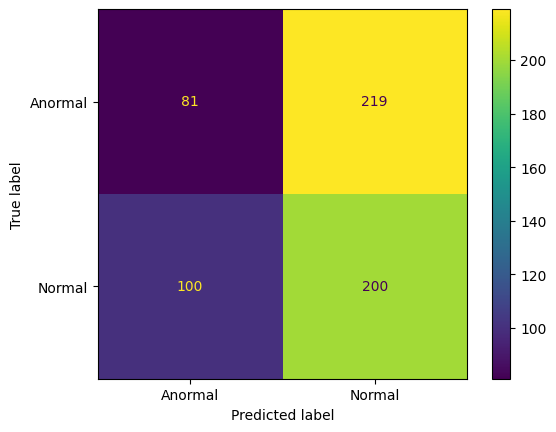

Accuracy score:  0.4683333333333333
              precision    recall  f1-score   support

           0       0.45      0.27      0.34       300
           1       0.48      0.67      0.56       300

    accuracy                           0.47       600
   macro avg       0.46      0.47      0.45       600
weighted avg       0.46      0.47      0.45       600

Acurácia cada classe


array([0.27      , 0.66666667])

In [20]:

test_path_uni = path+'/dataset-unitopatho/'
test_datagen_uni = ImageDataGenerator(rescale=1./255)
test_set_uni = test_datagen_uni.flow_from_directory(test_path_uni,
                                            target_size=(400, 400),
                                            batch_size=32,
                                            shuffle=False,
                                            class_mode='binary',classes=['ANORMAL','NORMAL'])



y_pred = resnet_model.predict(test_set_uni)
# Reset
#test_set_uni.reset()
#loss, acc = resnet_model.evaluate(test_set_uni)
#aux = np.argmax(aux, axis=1)
y_pred = np.where(y_pred > 0.5, 1, 0).flatten()
print("y predito:")
print(y_pred)
y_true = test_set_uni.classes
print("y real:")
print(y_true)
# Método para calcular o valor F1-Score
print('F1-Score: {}'.format(f1_score(y_true, y_pred, average='macro')))
# Método para calcular a Precision
print('Precision : {}'.format(precision_score(y_true, y_pred, average='macro')))
# Método para calcular o Recall
print('Recall: {}'.format(recall_score(y_true, y_pred, average='macro')))


print('Matriz de Confusão:')
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Anormal','Normal'])
cm_display.plot()
plt.savefig('Matriz-resnet-UNITOPATHO')
plt.show()

print ('Accuracy score: ', accuracy_score(y_true, y_pred))
#print('Acuracia obtida com o resnet no Conjunto de Teste UNITOPATHO: {:.2f}'.format(
#    acc))

print(classification_report(y_true, y_pred))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Acurácia cada classe')
cm.diagonal()